<h1> Ferrero interview take-home project

Since there was no column meaning explanation given I will use this markdown cell to write down the column meanings as I understand them, so there is a consistency for the readers as they go through the notebook

<b>Loan_ID</b>: Uniquely indentifies the number of the loan case

<b>Gender</b>: The gender of the applicant

<b>Married</b>: The marital status

<b>Dependents</b>: The number of children in the family

<b>Education</b>: The level of education of the applicant

<b>Self_Employed</b>: Is the applicant self-employed?

<b>ApplicantIncome</b>: Applicants income (assuming monthly)

<b>CoapplicantIncome</b>:  Co-applicants income (assuming monthly)

<b>LoanAmount</b>: The loan amount (assuming thousands)

<b>Loan_Amount_Term</b>: How long they will be paying off the loan (assuming months)

<b>Credit_History</b>: The creditworthiness of the applicant.

<b>Property_Area</b>: Where the applicant resides.

<b>Loan_Status</b>: The decision for the loan application

---------------------------------------

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [23]:
df_train = pd.read_csv('loan_sanction_train.csv')
df_test = pd.read_csv('loan_sanction_test.csv')

<h1> Excercise 1

<h3>Questions 1-2

In [26]:
df = df_train.copy()

display('columns and rows:', df.shape, df.head(15))

'columns and rows:'

(614, 13)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [90]:
print("Column types of df:")
print(df.dtypes)

Column types of df:
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


In [91]:
def check_for_odd_values(data):
    """Sometimes searching for null is not enough 
    as there have been cases of finding hardcoded 'null' strings in the data 
    or irrelevant words especially in non-validated systems
    I will use this function once to check the values of each column for wrong inputs
    """
    if data.duplicated(keep=False).sum() == 0:
        print('no duplicated rows')
    
    data = data.dropna()
    unique_ID = data['Loan_ID'].is_unique
    married = data['Married'].nunique()
    education = data['Education'].nunique()
    self_employed = data['Self_Employed'].nunique()
    credit = data['Credit_History'].nunique()
    label = data['Loan_Status'].nunique()
    if unique_ID and education == married == credit == label == 2:
        print('binary columns passed')
    print('')
    print('property area: ', data['Property_Area'].unique())
    print('dependents: ', data['Dependents'].unique())
    print('gender: ', data['Gender'].unique())
    
check_for_odd_values(df)

no duplicated rows
binary columns passed

property area:  ['Rural' 'Urban' 'Semiurban']
dependents:  ['1' '0' '2' '3+']
gender:  ['Male' 'Female']


Except for the null values the other inputs of the dataset seem valid

------------------------------------------

<h2>Question 3-4

In [93]:
null_percentage = df.isnull().mean() * 100
null_percentage = round(null_percentage, 2)
 
null_counts = df.isnull().sum()
null_info = pd.DataFrame({'Percentage': null_percentage, 'Null Count': null_counts})

print("Null values in each column:")
print(null_info[null_info['Null Count'] > 0])

Null values in each column:
                  Percentage  Null Count
Gender                  2.12          13
Married                 0.49           3
Dependents              2.44          15
Self_Employed           5.21          32
LoanAmount              3.58          22
Loan_Amount_Term        2.28          14
Credit_History          8.14          50


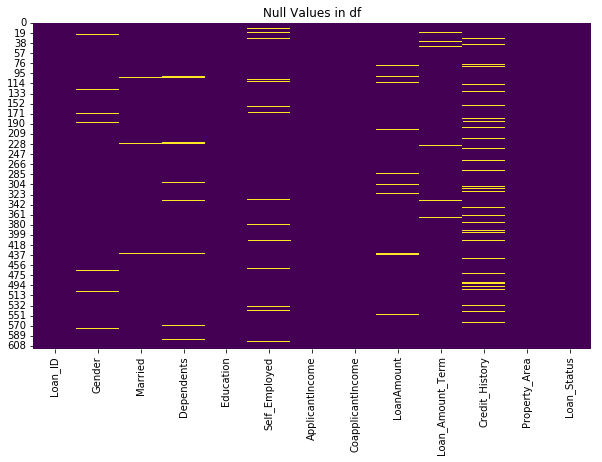

In [79]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Null Values in df')
plt.show()

<h5> Lets examine ways to address the null values problem

1. Deletion: Remove rows or columns with null values. This is suitable when the null values are relatively few compared to the total dataset and removing them won't significantly affect the analysis.

In [87]:
1 - df.dropna().shape[0] / df.shape[0] 

0.21824104234527686

As anyone can see deleting all rows containing null values results in deleting around 20% of our dataset. This is a large percentage, especially for this dataset which is relatively small in the first place

2. Forward or Backward Fill: Use the value from the previous or next row to fill null values

This is a technique that should be used in othe types of dataset such us time series where the data of the previous row is highly associated with the next one

3. Predictive Modeling: Use machine learning algorithms to predict missing values based on other features in the dataset.

Basically the scope is to train a model to predict the missing values based on other features in the data. For example KNN imputation. I would like to give this a a shot but maybe it exceeds the scope of the porject.

4. Statistical Imputation: Replace null values with a suitable substitute, such as the mean, median, mode, or a constant value.

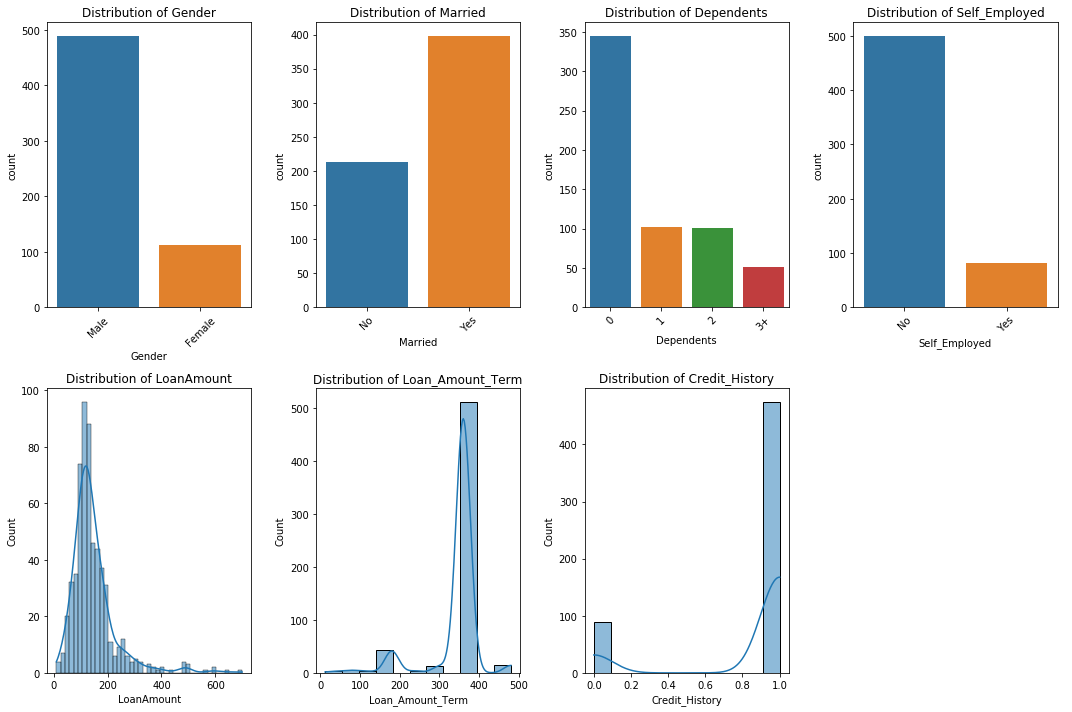

In [106]:
columns_with_nulls = [col for col in df.columns if df[col].isnull().any()]

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    num_cols = 4 
    num_rows = (len(columns_with_nulls) + num_cols - 1) // num_cols 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()

    for i, col in enumerate(df[columns_with_nulls]):
        if df_without_id[col].dtype == 'object':
            sns.countplot(data=df_without_id, x=col, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].tick_params(axis='x', rotation=45)
        else:
            sns.histplot(data=df_without_id, x=col, kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')

    # Hide the empty
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [194]:
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])


num_imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

if df.isnull().sum().sum()==0:
    print('imputed successfully')

imputed successfully


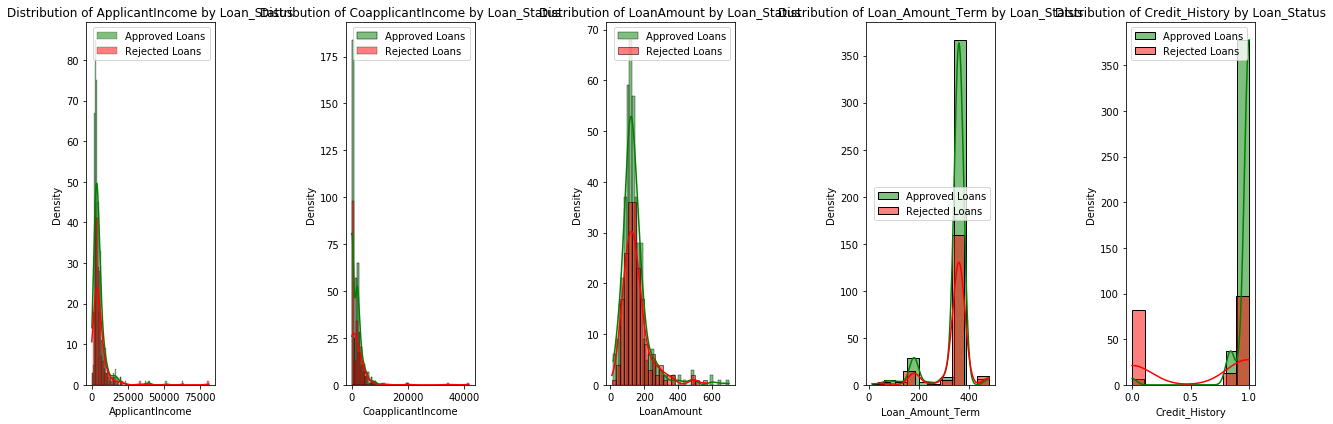

In [209]:
target_col = "Loan_Status"


# Filter data for Loan_Status == "Y" (approved loans)
approved_loans = df[df[target_col] == "Y"]

# Filter data for Loan_Status == "N" (rejected loans)
rejected_loans = df[df[target_col] == "N"]

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

        
    
    fig, axes = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(18, 6))

    # Create distribution plots for each numeric column by Loan_Status
    for i, col in enumerate(numerical_cols):
        sns.histplot(data=approved_loans, x=col, kde=True, color="green", label="Approved Loans", ax=axes[i])
        sns.histplot(data=rejected_loans, x=col, kde=True, color="red", label="Rejected Loans", ax=axes[i])
        axes[i].set_title(f"Distribution of {col} by {target_col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Density")
        axes[i].legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the combined plot
    plt.show()

In [243]:
df_without_id['Credit_History'].value_counts()

1.000000    475
0.000000     89
0.842199     50
Name: Credit_History, dtype: int64

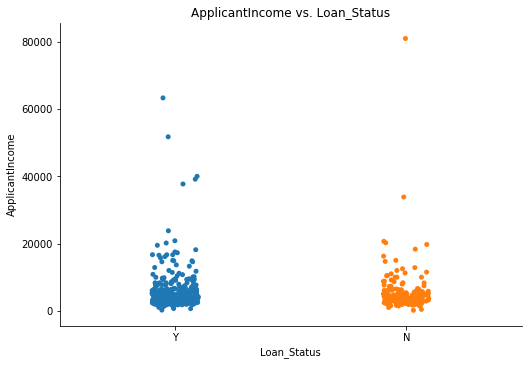

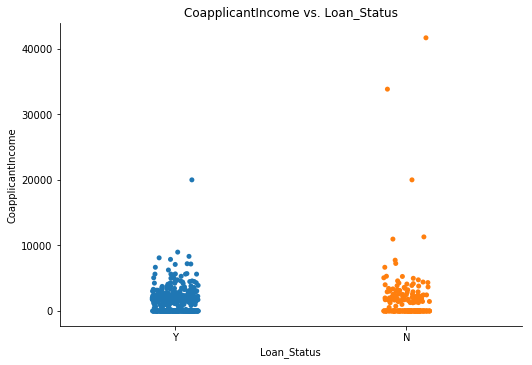

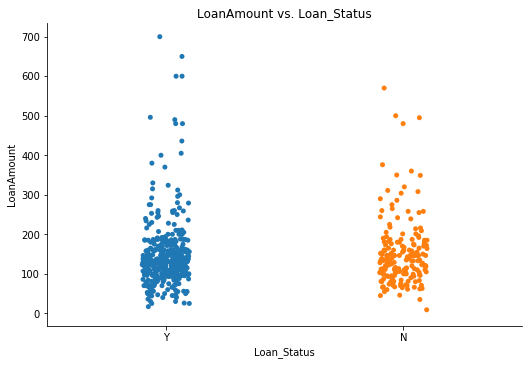

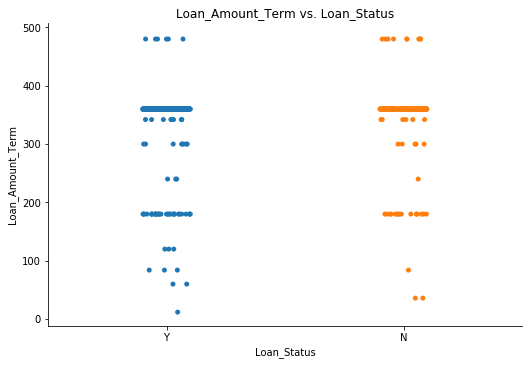

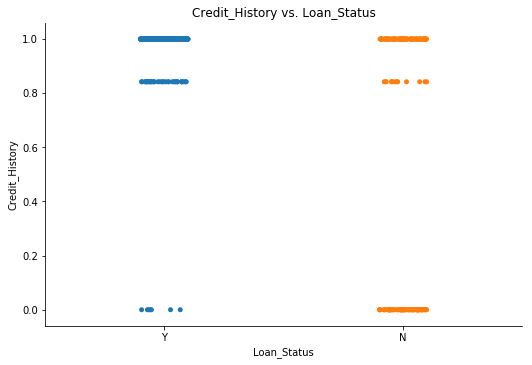

In [241]:
for col in numerical_cols:
    sns.catplot(data=df_without_id, x='Loan_Status', y=col, aspect=1.5)
    plt.title(f'{col} vs. Loan_Status')
    plt.show()



# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
    

#     for i, col in enumerate(numerical_cols):
#         sns.catplot(data=df_without_id, x='Loan_Status', y=col, ax=axes[i])

#         plt.show()

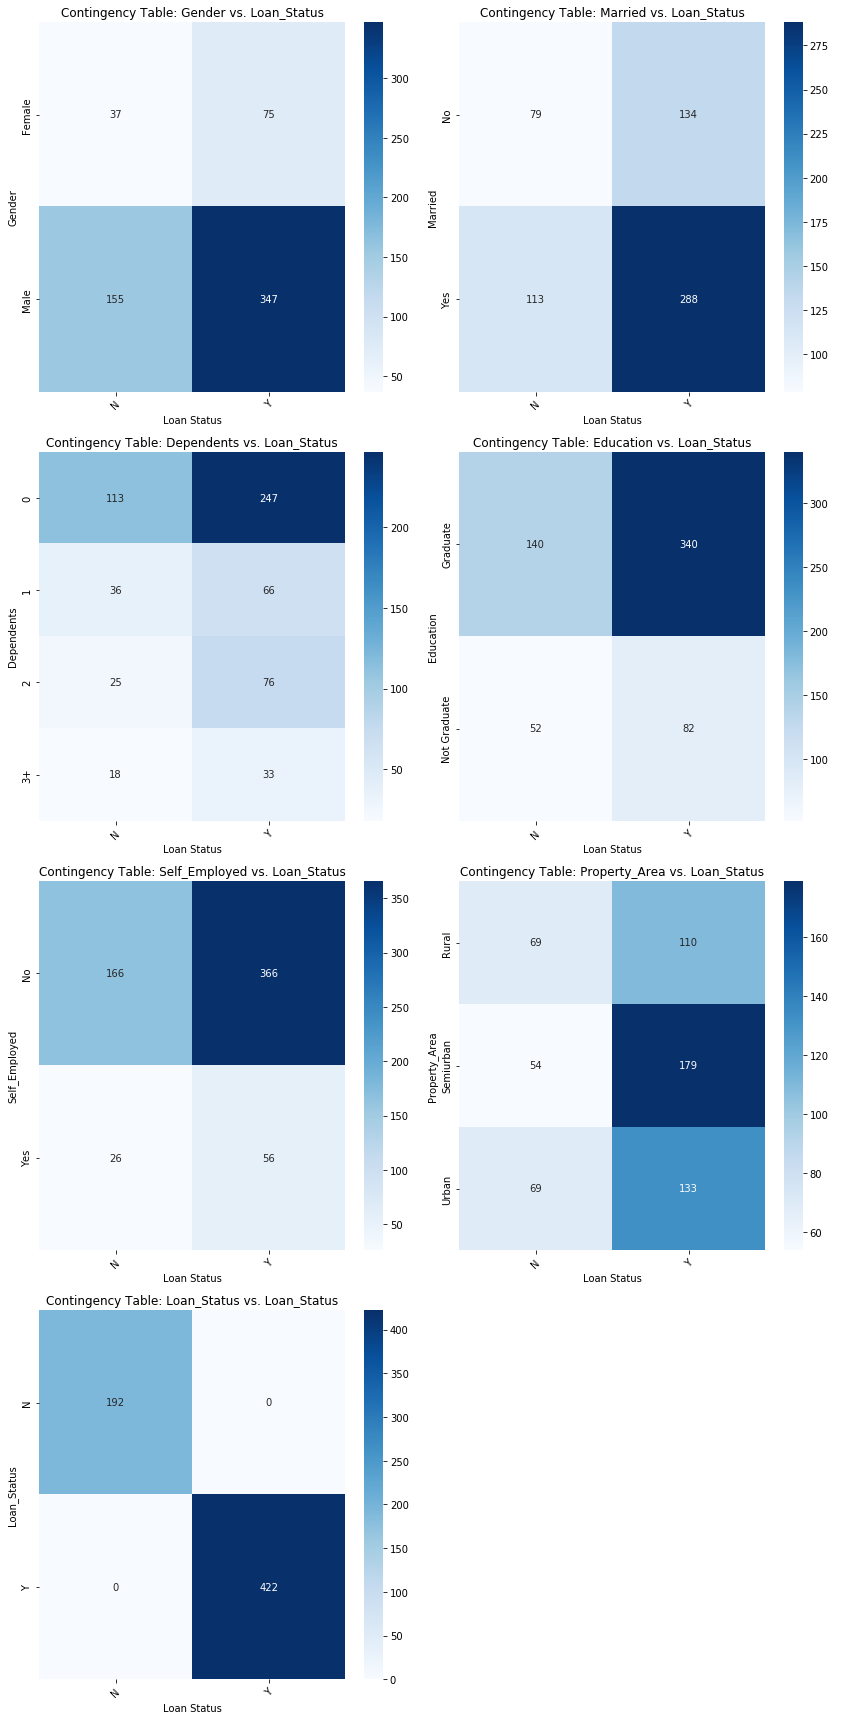

In [206]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.to_list()
categorical_cols = categorical_cols[1:]

num_plots = len(categorical_cols)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows*6))
axes = axes.flatten()

# Plot contingency tables (cross-tabulations) for each categorical variable
for i, col in enumerate(categorical_cols):
    cross_tab = pd.crosstab(df_without_id[col], df_without_id['Loan_Status'])
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Contingency Table: {col} vs. Loan_Status')
    axes[i].set_xlabel('Loan Status')
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplots
for j in range(num_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()